<a href="https://colab.research.google.com/github/Aniket-Singla/OFL-Round-1/blob/master/Ofl_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#imports 
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Data Gathering

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
google_drive = GoogleDrive(gauth)

#4/sAEiMO7dhEhgoPflGdqnwwEvge0fn_QnXbvmyxUPYku0NQhk8qlQJ6w

In [0]:
# Download a file based on its file ID.
#
file_id = '12OYCKGQp1VybvLM157ioLU4Bjt7PWpt-'
zip_file = google_drive.CreateFile({'id': file_id})
zip_file.GetContentFile('data.zip')

In [4]:
!unzip data.zip

Archive:  data.zip
   creating: Character + Digits data/
  inflating: Character + Digits data/Readme.txt  
  inflating: Character + Digits data/characters-digits-test.zip  
  inflating: Character + Digits data/characters-digits-train.zip  
  inflating: Character + Digits data/characters-digits-mapping.txt  


In [5]:
!unzip Character\ +\ Digits\ data/characters-digits-test.zip
!unzip Character\ +\ Digits\ data/characters-digits-train.zip
!mv Character\ +\ Digits\ data/characters-digits-mapping.txt .
!cat Character\ +\ Digits\ data/Readme.txt

Archive:  Character + Digits data/characters-digits-test.zip
  inflating: characters-digits-test.csv  
Archive:  Character + Digits data/characters-digits-train.zip
  inflating: characters-digits-train.csv  
Dataset Details:

train: 112,800
test: 18,800
total: 131,600
classes: 47 (Due to the low availabilty of images differentiating characters such as u,v,x,y,etc...)


Refer to the characters-digits-mapping file to get the ASCII codes for the labels...




## Load Data

In [0]:
# import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
# train_df = pd.read_csv('../input/ofl-data/Character + Digits data/characters-digits-train/characters-digits-train.csv', header=None)
# test_df = pd.read_csv('../input/ofl-data/Character + Digits data/characters-digits-test/characters-digits-test.csv', header=None)
train_df = pd.read_csv('characters-digits-train.csv', header=None)
test_df = pd.read_csv('characters-digits-test.csv', header=None)

In [8]:
# mapping = pd.read_csv('../input/ofl-data/Character + Digits data/characters-digits-mapping.txt',header=None,sep=' ')
mapping = pd.read_csv('characters-digits-mapping.txt',header=None,sep=' ')
mapping.head()
classes_t3 = mapping[1].apply(chr).values
print(classes_t3)
index_to_ascii = mapping[1].values
print(index_to_ascii)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'd' 'e' 'f' 'g' 'h' 'n' 'q' 'r' 't']
[ 48  49  50  51  52  53  54  55  56  57  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  97  98 100 101 102 103 104 110 113 114 116]


In [9]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Creation Of Labels for T1, T2 and T3

In [0]:
labels_train_t3 = train_df[0].values
labels_test_t3 = test_df[0].values

In [0]:
labels_train_t1 = (labels_train_t3>9).astype(int)
labels_test_t1 = (labels_test_t3>9).astype(int)

In [0]:
def create_t2_labels(labels):
  labels_t2 = labels.copy()
  vowels_index = [10,14,18,24,30,36,39]
  for i, label in enumerate(labels):
    # print(label)
    if label<=9:
        if label%2==0:
            labels_t2[i]=0
        else:
            labels_t2[i]=1
    else:
        if label in vowels_index:
            labels_t2[i]=0
        else:
            labels_t2[i]=1
  return labels_t2

In [0]:
def create_t2_labels_eval(labels):
  labels_t2 = labels.copy()
  vowels_index = [10,14,18,24,30,36,39]
  for i, label in enumerate(labels):
    # print(label)
    if label<=9:
        if label%2==0:
            labels_t2[i]=0
        else:
            labels_t2[i]=1
    else:
        if label in vowels_index:
            labels_t2[i]=2
        else:
            labels_t2[i]=3
  return labels_t2

In [0]:
labels_train_t2 = create_t2_labels(labels_train_t3)
labels_train_t2_eval = create_t2_labels_eval(labels_train_t3)
labels_test_t2 = create_t2_labels(labels_test_t3)
labels_test_t2_eval = create_t2_labels_eval(labels_test_t3)

In [0]:
train_df['labels_t1'] = labels_train_t1
test_df['labels_t1'] = labels_test_t1
train_df['labels_t2'] = labels_train_t2
train_df['labels_t2_eval'] = labels_train_t2_eval
test_df['labels_t2'] = labels_test_t2
test_df['labels_t2_eval'] = labels_test_t2_eval
train_df['labels_t3'] = labels_train_t3
test_df['labels_t3'] = labels_test_t3

In [0]:
images_columns = list(range(1,785))
labels_train = train_df[['labels_t1','labels_t2','labels_t3']].values
images_train = train_df[images_columns].values

In [0]:
labels_test = test_df[['labels_t1','labels_t2','labels_t3']].values
images_test = test_df[images_columns].values

# Util + Settings

## Creation Of DataSet

In [0]:
def create_train_val_dataset(images_train,labels_train,test_size=0.1):

    # images_train = images_train.reshape(images_train.shape[0],1,28,28).transpose(0,1,3,2)
    # images_test = images_test.reshape(images_test.shape[0],1,28,28).transpose(0,1,3,2)

    images_train = images_train.reshape(images_train.shape[0],1,28,28).transpose(0,1,3,2)    
    features_train, features_val, targets_train, targets_val = train_test_split(images_train,
                                                                                 labels_train,
                                                                                 test_size = test_size,
                                                                                 random_state = 42) 

    featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
    targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

    featuresVal = torch.from_numpy(features_val).type(torch.FloatTensor)
    targetsVal = torch.from_numpy(targets_val).type(torch.LongTensor) # data type is long

    print(features_train.shape,targets_train.shape)
    train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
    val = torch.utils.data.TensorDataset(featuresVal,targetsVal)

    return train, val
    
def create_test_dataset(images_test,labels_test):
    images_test = images_test.reshape(images_test.shape[0],1,28,28).transpose(0,1,3,2)
    featuresTest = torch.from_numpy(images_test).type(torch.FloatTensor)
    targetsTest = torch.from_numpy(labels_test).type(torch.LongTensor)
    return torch.utils.data.TensorDataset(featuresTest,targetsTest)

## Printing Image

[]

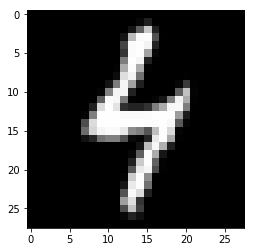

In [19]:
# fname = 'image.png'
pixels = images_train[64553].reshape(28,28)
image = Image.fromarray(pixels,'L')
# arr = np.asarray(image)
plt.imshow(pixels.transpose(), cmap='gray')
plt.plot()
# image.show()

In [0]:
def imshow(img,title):
    npimg = img.numpy() #/ 2 + 0.5  #denormalize image
    plt.figure()  # width, height
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Helper function to show a batch
def show_images_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, label_batch = sample_batched
    images_batch = images_batch.type(torch.LongTensor)
    # print(images_batch.shape)
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # grid = utils.make_grid(images_batch)
    # plt.imshow(grid.numpy().transpose((1, 2, 0)))
    img = torchvision.utils.make_grid(images_batch)
    label_list_char = []
    # print(label_batch.shape)
    label_batch_list = list(label_batch.numpy())
    for inde in label_batch_list:
        label_list_char.append(chr(index_to_ascii[inde]))
    imshow(img,title=label_list_char)

# for i_batch, sample_batched in enumerate(train_loader_t1):

#     # observe 4th batch and stop.
#     if i_batch == 3:
#         plt.figure()
#         show_landmarks_batch(sample_batched)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

## Saving and Gathering Models From Drive

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Evaluation + Confusion Matrix Plotter

In [0]:
def evaluation(dataloader,eval_net,calc_loss=False,loss_fn=None):
    eval_net.eval()
    total, correct = 0, 0
    loss = 0 
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = eval_net(inputs)

        if calc_loss:
          loss += loss_fn(outputs, labels)
        
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    eval_net.train()

    if calc_loss:
      return 100 * correct / total, loss/total
      
    return 100 * correct / total

In [0]:
def plot_confusion_matrix(data_loader,net,num_labels,classes=None,path=None):
    confusion_matrix = np.zeros([num_labels,num_labels])
    net= net.cpu()
    for data, label in data_loader:
        output = net(data)
        _, pred = torch.max(output,1)
        for x, y in zip(pred.numpy(),label.numpy()):
            confusion_matrix[x][y]+= 1
            
    #plot at last of creating confusion_matrix
    if type(classes) == type(None):
        classes = np.arange(num_labels)
    fig, ax = plt.subplots(figsize=(num_labels*2,num_labels*2))
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
               yticks=np.arange(confusion_matrix.shape[0]),
               xticklabels=classes, yticklabels=classes,
               ylabel='True label',
               xlabel='Predicted label',
               title='Confusion Matrix')
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, int(confusion_matrix[i, j]),
                    ha="center", va="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")

    fig.tight_layout()
    if path:
        plt.savefig(path)
    else :
        plt.savefig('confusion.jpg')
    net.to(device)

## Device Loader (GPU) and base path

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_and_save_mode = True
PATH = '/content/gdrive/My Drive'

## Train Function

In [0]:
def train_model(train_loader,val_loader,test_loader,net,loss_fn,opt,max_epochs=16):
  loss_arr = []
  loss_epoch_arr = []

  for epoch in range(max_epochs):

      for i, data in enumerate(train_loader, 0):

          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          opt.zero_grad()
          
          outputs = net(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          opt.step()
          loss_arr.append(loss.item())
      loss_epoch_arr.append(loss.item())
          
      print('Epoch:%d/%d :'%(epoch+1,max_epochs))
      print('Validation acc: %0.2f, Test acc : %0.2f' %
            ( evaluation(val_loader,net),evaluation(test_loader,net)))
      
      
  plt.plot(loss_epoch_arr)
  plt.show()

In [0]:
def train_v2(train_loader,net,loss_fn,opt,epoch):
    
    net.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
      
        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % 100 == 0:
            pos = epoch * len(train_loader) + batch_id            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))
      
    return loss

In [0]:
def test_v2(val_loader,net,loss_fn,epoch,train_acc=True,train_loader=None):
    
    net.eval()
    validation_loss,train_loss = 0,0
    correct = 0
    
    with torch.no_grad():
        if train_acc : 
          train_accuracy, train_loss = evaluation(train_loader,net,calc_loss=True,loss_fn=loss_fn)
          print('\nTrain set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.
                format(train_loss,  train_accuracy))
        
        validation_accuracy, validation_loss = evaluation(val_loader,net,calc_loss=True,loss_fn=loss_fn)
        
        print('\nValidation set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.
              format(validation_loss,  validation_accuracy))
        
        net.train()
        
              
        # if epoch == args.epochs:
        #   plot_confusion_matrix(test_loader,net,num_labels,classes=None,path=None)


# Task 1

In [28]:
train , val = create_train_val_dataset(images_train,labels_train[:,0],test_size=0.2)
test = create_test_dataset(images_test,labels_test[:,0])

(90240, 1, 28, 28) (90240,)


In [0]:
train_loader_t1 = DataLoader(train, batch_size=4,
                        shuffle=True)
val_loader_t1 = DataLoader(val, batch_size=4,
                        shuffle=True)
test_loader_t1 = DataLoader(test, batch_size=4,
                        shuffle=True)

## Training

In [0]:
class LeNet_T1(nn.Module):
    def __init__(self): 
        super().__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 6, 5),         
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   
        )
        self.fc_model = nn.Sequential(
            nn.Linear(256,120),        
            nn.Tanh(),
            nn.Linear(120,84),       
            nn.Tanh(),
            nn.Linear(84,2)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [0]:
net_t1 = LeNet_T1().to(device)
loss_fn = nn.CrossEntropyLoss()
opt_t1 = optim.Adam(net_t1.parameters())

MODEL_T1_PATH = PATH + '/trained_models/model_t1.pth'

if load_and_save_mode:
  checkpoint = torch.load(MODEL_T1_PATH)
  net_t1.load_state_dict(checkpoint['model_state_dict'])
  opt_t1.load_state_dict(checkpoint['optimizer_state_dict'])
  # epoch = checkpoint['epoch']
  # loss = checkpoint['loss']

Epoch:1/16 :
Validation acc: 91.56, Test acc : 91.52
Epoch:2/16 :
Validation acc: 91.59, Test acc : 91.24
Epoch:3/16 :
Validation acc: 91.62, Test acc : 91.54
Epoch:4/16 :
Validation acc: 91.41, Test acc : 91.49
Epoch:5/16 :
Validation acc: 91.70, Test acc : 91.45
Epoch:6/16 :
Validation acc: 91.58, Test acc : 91.37
Epoch:7/16 :
Validation acc: 91.69, Test acc : 91.66
Epoch:8/16 :
Validation acc: 91.45, Test acc : 91.31
Epoch:9/16 :
Validation acc: 91.50, Test acc : 91.24
Epoch:10/16 :
Validation acc: 91.93, Test acc : 91.86
Epoch:11/16 :
Validation acc: 91.34, Test acc : 91.12
Epoch:12/16 :
Validation acc: 91.76, Test acc : 91.63
Epoch:13/16 :
Validation acc: 90.84, Test acc : 91.02
Epoch:14/16 :
Validation acc: 91.58, Test acc : 91.24
Epoch:15/16 :
Validation acc: 91.78, Test acc : 91.76
Epoch:16/16 :
Validation acc: 91.67, Test acc : 91.60


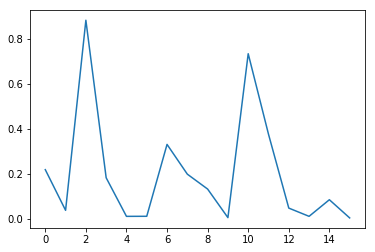

In [32]:
train_model(train_loader_t1,val_loader_t1,test_loader_t1,net_t1,loss_fn,opt_t1,max_epochs=16)

In [0]:
#new train and test functions
# for epoch in range(1, 3 + 1):
#                 train_v2(train_loader,net_t1,loss_fn,opt_t1,epoch)
#                 test_v2(val_loader,net_t1,loss_fn,epoch,train_acc=False)

In [0]:
if load_and_save_mode:
  torch.save({
              # 'epoch': epoch,
              'model_state_dict': net_t1.state_dict(),
              'optimizer_state_dict': opt_t1.state_dict(),
              # 'loss': loss,
              }, MODEL_T1_PATH)

## Inference

In [0]:
data_iter_t1 = iter(train_loader_t1)

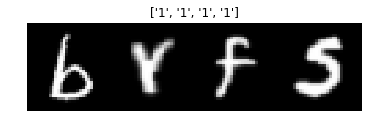

tensor([1, 1, 1, 1])




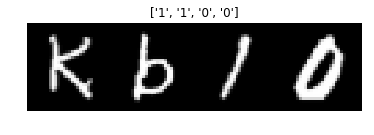

tensor([1, 1, 1, 1])




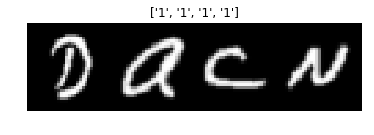

tensor([1, 1, 1, 1])




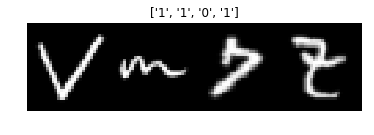

tensor([1, 1, 0, 1])




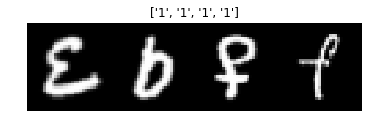

tensor([1, 1, 1, 1])




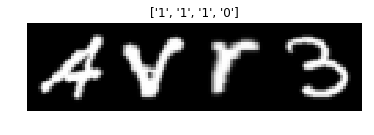

tensor([1, 1, 1, 0])




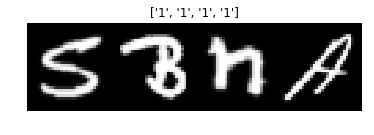

tensor([1, 0, 1, 1])




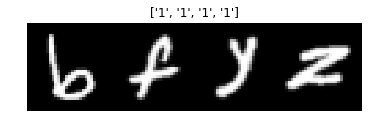

tensor([1, 1, 1, 1])




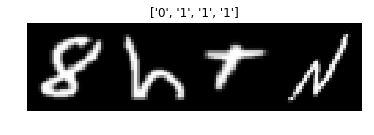

tensor([0, 1, 1, 1])




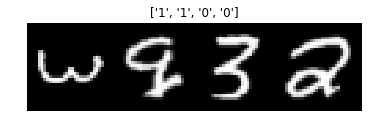

tensor([1, 1, 0, 0])




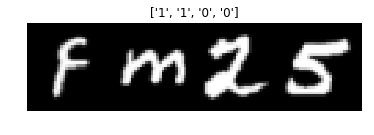

tensor([1, 1, 1, 0])




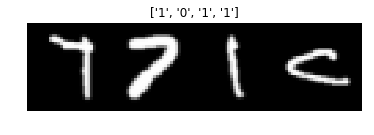

tensor([0, 0, 1, 1])




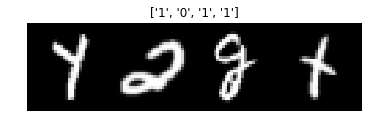

tensor([1, 0, 1, 1])




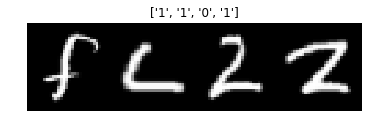

tensor([1, 1, 0, 1])




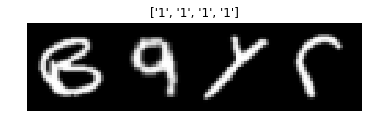

tensor([1, 1, 1, 1])




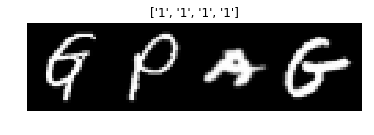

tensor([1, 1, 1, 1])




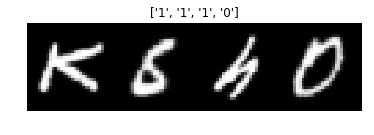

tensor([1, 0, 1, 0])




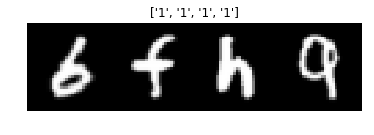

tensor([1, 1, 1, 1])




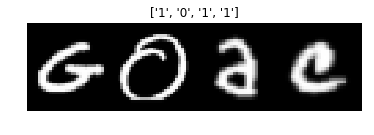

tensor([1, 1, 1, 1])




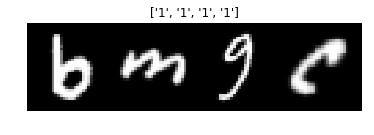

tensor([1, 1, 1, 1])




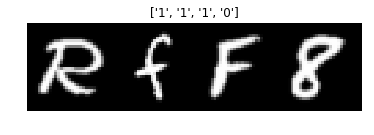

tensor([1, 1, 1, 0])




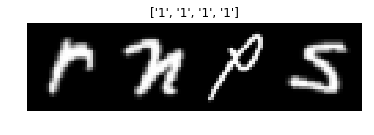

tensor([1, 1, 1, 1])




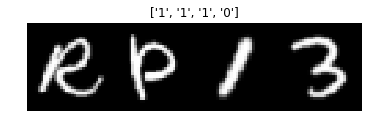

tensor([1, 1, 1, 0])




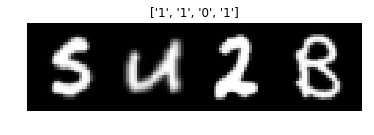

tensor([1, 1, 0, 1])




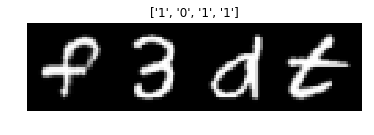

tensor([1, 0, 1, 1])




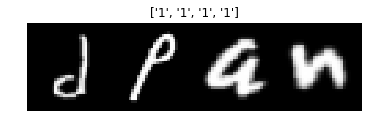

tensor([1, 1, 1, 1])




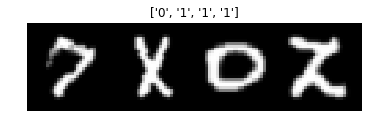

tensor([0, 1, 1, 1])




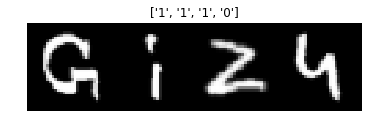

tensor([1, 1, 1, 0])




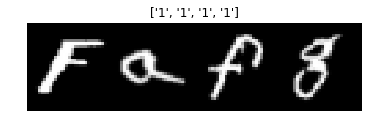

tensor([1, 1, 1, 1])




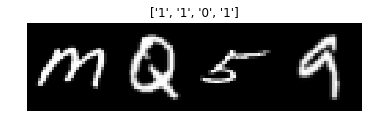

tensor([1, 1, 0, 1])




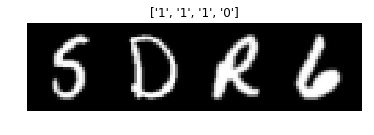

tensor([1, 1, 1, 0])




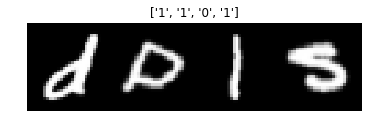

tensor([1, 1, 1, 1])




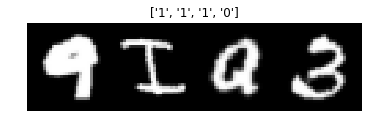

tensor([1, 1, 1, 0])




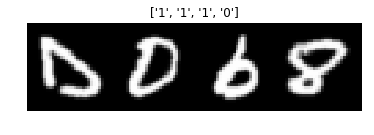

tensor([1, 1, 1, 0])




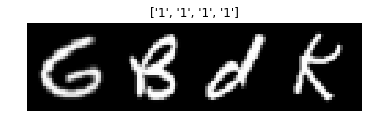

tensor([1, 1, 1, 1])




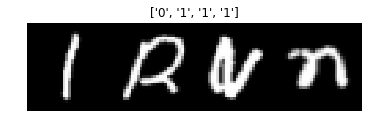

tensor([1, 1, 1, 1])




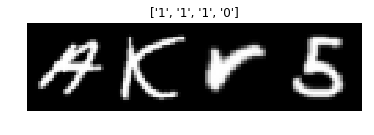

tensor([1, 1, 1, 0])




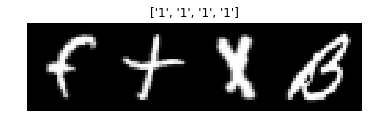

tensor([1, 1, 1, 1])




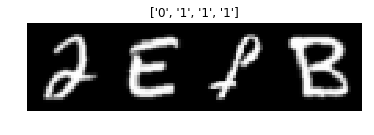

tensor([0, 1, 1, 1])




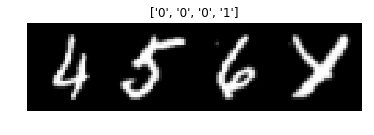

tensor([1, 0, 0, 1])




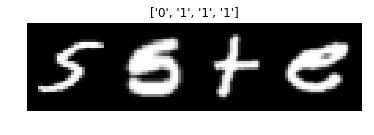

tensor([1, 1, 1, 1])




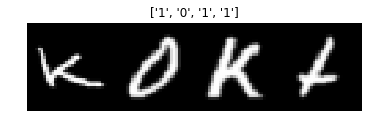

tensor([1, 0, 1, 1])




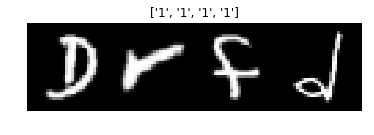

tensor([1, 1, 1, 1])




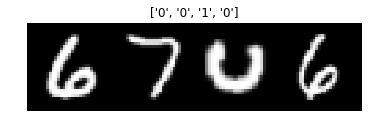

tensor([0, 0, 1, 0])




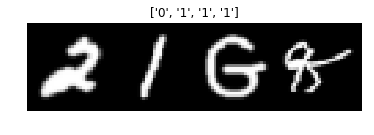

tensor([0, 1, 1, 1])




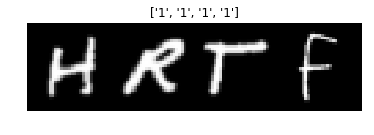

tensor([1, 1, 1, 1])




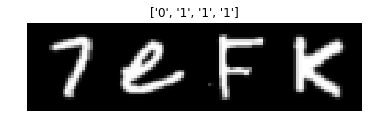

tensor([0, 1, 1, 1])




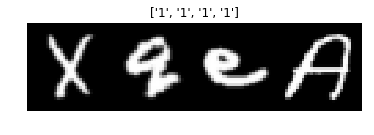

tensor([1, 1, 1, 1])




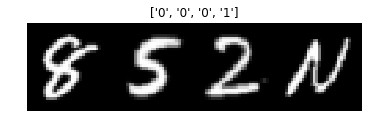

tensor([0, 0, 0, 1])




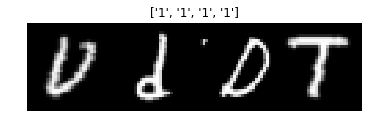

tensor([1, 1, 1, 1])




In [36]:
net_t1.cpu()
for i in range(50):
  batch_t1 = data_iter_t1.next()
  show_images_batch(batch_t1)
  out = net_t1(batch_t1[0])
  _, pred = torch.max(out,1)
  print(pred)
  print('\n')

## Accuracy on Test Set

In [37]:
net_t1.to(device)
evaluation(test_loader_t1,net_t1,calc_loss=False,loss_fn=None)

91.60106382978724

# Task 2
We are using different labels for train and evaluation purposes.

Train Labels:
if letter : 0-> vowel , 1-> consonant
if digit : 0-> even, 1-> odd

Test Labels:
0-> digit, even
1-> digit, odd
2-> letter, vowel
3-> letter, consonant

## DataSet And DataLoaders


In [0]:
digits_train_df = train_df.loc[train_df['labels_t1']==0]
digits_test_df = test_df.loc[test_df['labels_t1']==0]

letters_train_df = train_df.loc[train_df['labels_t1']==1]
letters_test_df = test_df.loc[test_df['labels_t1']==1]

digit_images_train = digits_train_df[images_columns].values
letter_images_train = letters_train_df[images_columns].values
digit_labels_train = digits_train_df['labels_t2'].values
letter_labels_train = letters_train_df['labels_t2'].values

digit_images_test = digits_test_df[images_columns].values
letter_images_test = letters_test_df[images_columns].values
digit_labels_test = digits_test_df['labels_t2'].values
letter_labels_test = letters_test_df['labels_t2'].values

## for evaluation only
labels_train_t2_eval = train_df['labels_t2_eval'].values
labels_test_t2_eval = test_df['labels_t2_eval'].values

In [39]:
# Training data and Labels
digits_train_dataset, digits_val_dataset = create_train_val_dataset(digit_images_train,digit_labels_train)
digits_test_dataset = create_test_dataset(digit_images_test,digit_labels_test)

letters_train_dataset, letters_val_dataset = create_train_val_dataset(letter_images_train,letter_labels_train)
letters_test_dataset = create_test_dataset(letter_images_test,letter_labels_test)

(21600, 1, 28, 28) (21600,)
(79920, 1, 28, 28) (79920,)


In [0]:
test_set_for_eval = create_test_dataset(images_test,labels_test_t2_eval)
test_loader_eval = DataLoader(test_set_for_eval, batch_size=1,
                        shuffle=True)

## Model For Digits and Letters

In [0]:
class LeNet_T2(nn.Module):
    def __init__(self): 
        super().__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(256,120),
            nn.Tanh(),
            nn.Linear(120,84),
            nn.Tanh(),
            nn.Linear(84,2)
           
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

## Training Digits Model

In [0]:
# device = torch.device("cpu")

In [0]:
digits_net= LeNet_T2().to(device)
loss_fn_t2_digits = nn.CrossEntropyLoss()
opt_t2_digits = optim.Adam(digits_net.parameters(),lr=0.01, betas=(0.9, 0.999))

In [0]:

MODEL_T2_DIGITS_PATH = PATH + '/trained_models/model_t2_digit.pth'

if load_and_save_mode:
  checkpoint = torch.load(MODEL_T2_DIGITS_PATH)
  digits_net.load_state_dict(checkpoint['model_state_dict'])
  opt_t2_digits.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
train_loader_t2_digits = DataLoader(digits_train_dataset, batch_size=4,
                        shuffle=True)
val_loader_t2_digits = DataLoader(digits_val_dataset, batch_size=4,
                        shuffle=True)
test_loader_t2_digits = DataLoader(digits_test_dataset, batch_size=4,
                        shuffle=True)

Epoch:1/16 :
Validation acc: 99.12, Test acc : 98.92
Epoch:2/16 :
Validation acc: 98.96, Test acc : 98.85
Epoch:3/16 :
Validation acc: 98.38, Test acc : 98.42
Epoch:4/16 :
Validation acc: 98.92, Test acc : 98.85
Epoch:5/16 :
Validation acc: 98.75, Test acc : 98.53
Epoch:6/16 :
Validation acc: 98.62, Test acc : 98.70
Epoch:7/16 :
Validation acc: 98.88, Test acc : 98.95
Epoch:8/16 :
Validation acc: 99.08, Test acc : 98.85
Epoch:9/16 :
Validation acc: 98.88, Test acc : 98.72
Epoch:10/16 :
Validation acc: 98.62, Test acc : 98.90
Epoch:11/16 :
Validation acc: 99.08, Test acc : 98.83
Epoch:12/16 :
Validation acc: 98.83, Test acc : 99.05
Epoch:13/16 :
Validation acc: 98.75, Test acc : 99.17
Epoch:14/16 :
Validation acc: 98.83, Test acc : 98.78
Epoch:15/16 :
Validation acc: 98.75, Test acc : 98.90
Epoch:16/16 :
Validation acc: 99.17, Test acc : 98.88


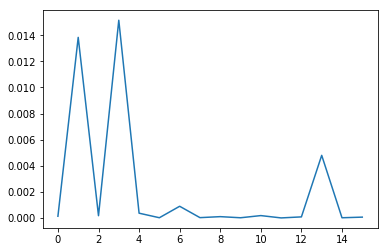

In [46]:
train_model(train_loader_t2_digits,val_loader_t2_digits,test_loader_t2_digits,digits_net,loss_fn_t2_digits,opt_t2_digits,max_epochs=16)

Train Epoch: 1 [0/21600 (0%)]	Loss: 0.000
Train Epoch: 1 [400/21600 (2%)]	Loss: 0.006
Train Epoch: 1 [800/21600 (4%)]	Loss: 0.000
Train Epoch: 1 [1200/21600 (6%)]	Loss: 0.000
Train Epoch: 1 [1600/21600 (7%)]	Loss: 0.000
Train Epoch: 1 [2000/21600 (9%)]	Loss: 0.000
Train Epoch: 1 [2400/21600 (11%)]	Loss: 0.000
Train Epoch: 1 [2800/21600 (13%)]	Loss: 0.000
Train Epoch: 1 [3200/21600 (15%)]	Loss: 0.006
Train Epoch: 1 [3600/21600 (17%)]	Loss: 0.074
Train Epoch: 1 [4000/21600 (19%)]	Loss: 0.000
Train Epoch: 1 [4400/21600 (20%)]	Loss: 0.001
Train Epoch: 1 [4800/21600 (22%)]	Loss: 0.000
Train Epoch: 1 [5200/21600 (24%)]	Loss: 0.000
Train Epoch: 1 [5600/21600 (26%)]	Loss: 0.000
Train Epoch: 1 [6000/21600 (28%)]	Loss: 0.000
Train Epoch: 1 [6400/21600 (30%)]	Loss: 0.000
Train Epoch: 1 [6800/21600 (31%)]	Loss: 0.000
Train Epoch: 1 [7200/21600 (33%)]	Loss: 0.003
Train Epoch: 1 [7600/21600 (35%)]	Loss: 0.000
Train Epoch: 1 [8000/21600 (37%)]	Loss: 0.000
Train Epoch: 1 [8400/21600 (39%)]	Loss: 0.010

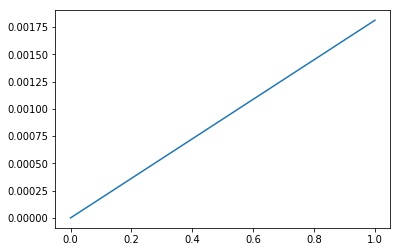

In [86]:
# new train and test functions
digits_net.to(device)
loss_epoch_arr =[]
for epoch in range(1, 2 + 1):
    loss_epoch = train_v2(train_loader_t2_digits,digits_net,loss_fn_t2_digits,opt_t2_digits,epoch)
    test_v2(val_loader_t2_digits,digits_net,loss_fn_t2_digits,epoch,train_acc=False)
    loss_epoch_arr.append(loss_epoch)
plt.plot(loss_epoch_arr)
plt.show()

In [0]:
if load_and_save_mode:
  torch.save({
              # 'epoch': epoch,
              'model_state_dict': digits_net.state_dict(),
              'optimizer_state_dict': opt_t2_digits.state_dict(),
              # 'loss': loss,
              }, MODEL_T2_DIGITS_PATH)

## Inference

In [0]:
data_iter_digits = iter(train_loader_t2_digits)

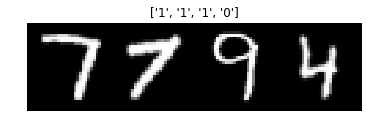

tensor([1, 1, 1, 0])




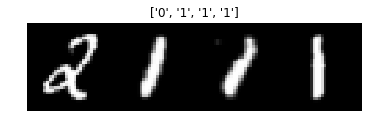

tensor([0, 1, 1, 1])




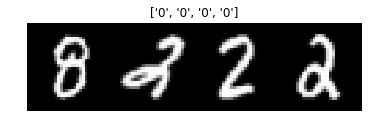

tensor([0, 0, 0, 0])




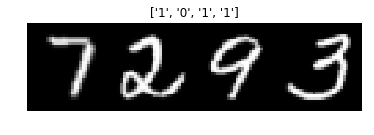

tensor([1, 0, 1, 1])




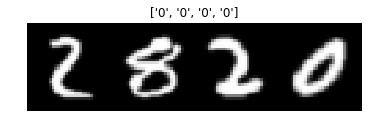

tensor([0, 0, 0, 0])




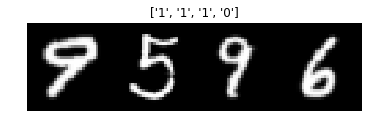

tensor([1, 1, 1, 0])




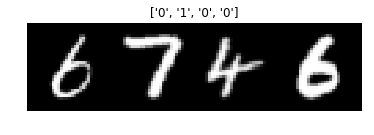

tensor([0, 1, 0, 0])




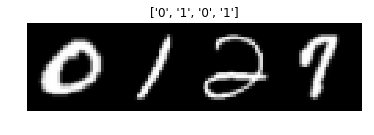

tensor([0, 1, 0, 1])




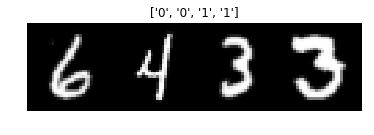

tensor([0, 0, 1, 1])




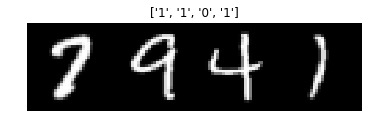

tensor([1, 1, 0, 1])




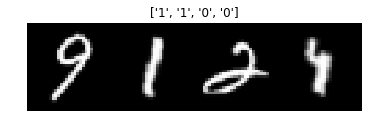

tensor([1, 1, 0, 0])




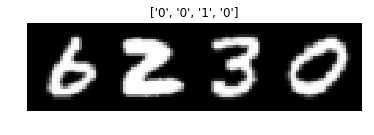

tensor([0, 0, 1, 0])




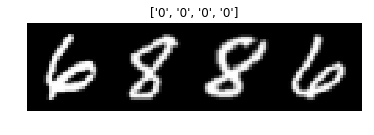

tensor([0, 0, 0, 0])




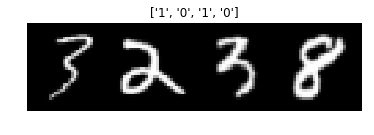

tensor([1, 0, 1, 0])




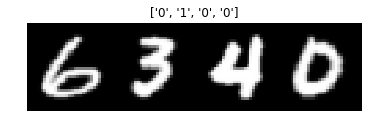

tensor([0, 1, 0, 0])




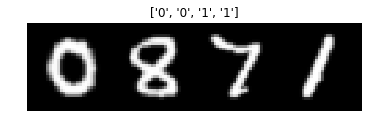

tensor([0, 0, 1, 1])




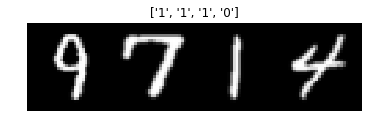

tensor([1, 1, 1, 0])




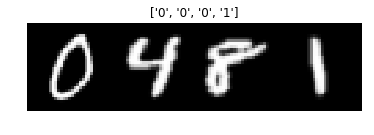

tensor([0, 0, 0, 1])




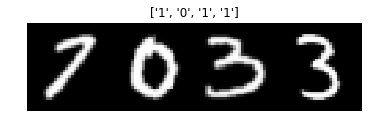

tensor([1, 0, 1, 1])




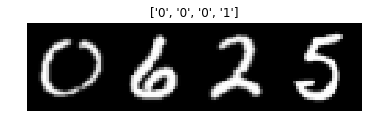

tensor([0, 0, 0, 1])




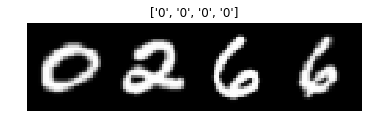

tensor([0, 0, 0, 0])




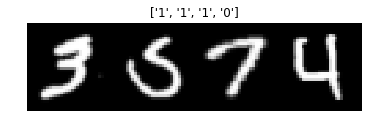

tensor([1, 1, 1, 0])




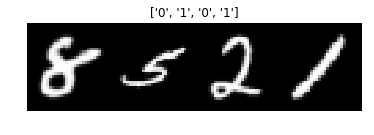

tensor([0, 1, 0, 1])




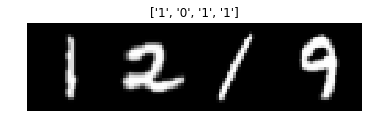

tensor([1, 0, 1, 1])




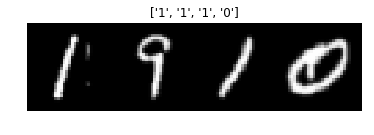

tensor([1, 1, 1, 0])




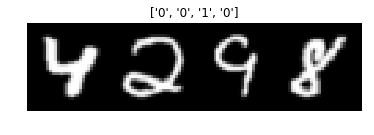

tensor([0, 0, 1, 0])




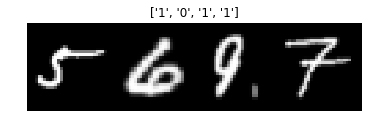

tensor([1, 0, 1, 1])




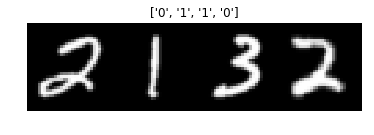

tensor([0, 1, 1, 0])




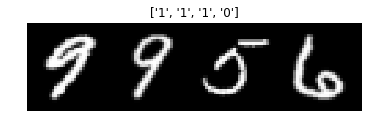

tensor([1, 1, 1, 0])




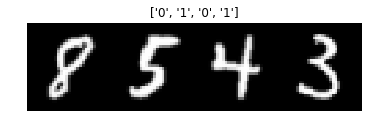

tensor([0, 1, 0, 1])




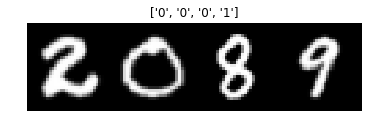

tensor([0, 0, 0, 1])




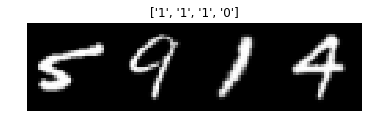

tensor([1, 1, 1, 0])




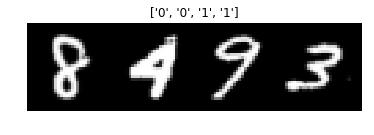

tensor([0, 0, 1, 1])




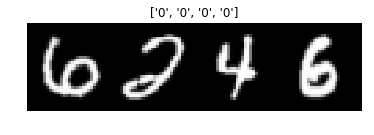

tensor([0, 0, 0, 0])




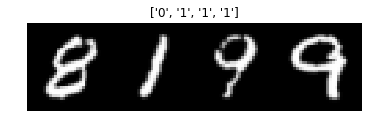

tensor([0, 1, 1, 1])




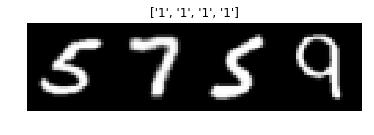

tensor([1, 1, 1, 1])




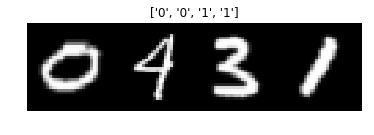

tensor([0, 0, 1, 1])




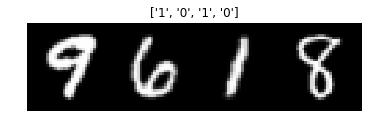

tensor([1, 0, 1, 0])




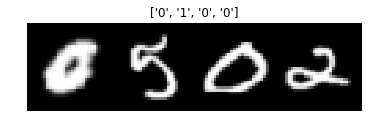

tensor([0, 1, 0, 0])




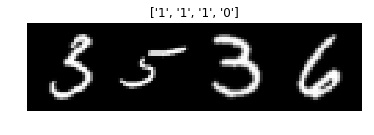

tensor([1, 1, 1, 0])




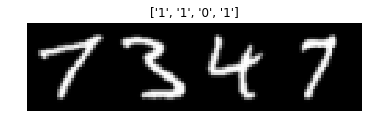

tensor([1, 1, 0, 1])




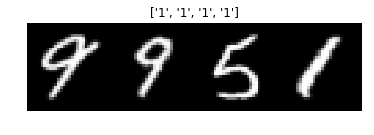

tensor([1, 1, 1, 1])




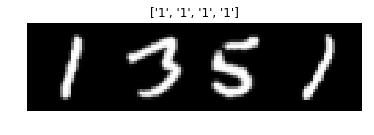

tensor([1, 1, 1, 1])




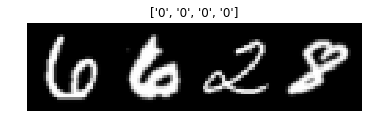

tensor([0, 0, 0, 0])




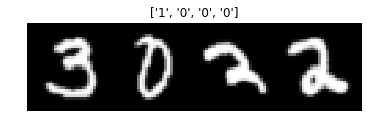

tensor([1, 0, 0, 0])




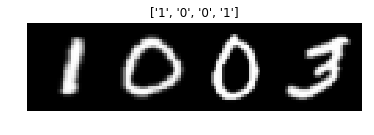

tensor([1, 0, 0, 1])




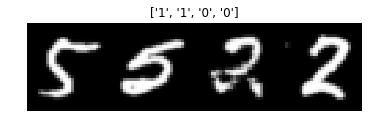

tensor([1, 1, 0, 0])




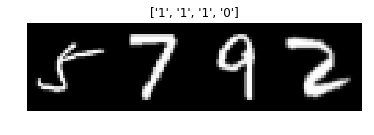

tensor([1, 1, 1, 0])




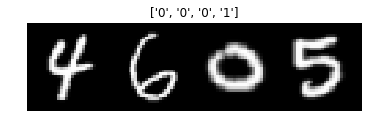

tensor([0, 0, 0, 1])




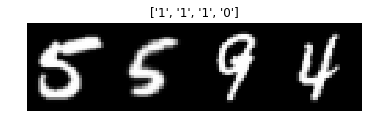

tensor([1, 1, 1, 0])




In [89]:
for i in range(50):
  batch_digits = data_iter_digits.next()
  show_images_batch(batch_digits)
  digits_net.cpu()
  out = digits_net(batch_digits[0])
  _, pred = torch.max(out,1)
  print(pred)
  print('\n')

## Training Letters Model

In [0]:
# device = torch.device('cpu')

In [0]:
letters_net= LeNet_T2().to(device)
loss_fn_t2_letters = nn.CrossEntropyLoss()
opt_t2_letters = optim.Adam(letters_net.parameters())

In [0]:
MODEL_T2_LETTERS_PATH = PATH + '/trained_models/model_t2_letter.pth'

if load_and_save_mode:
  checkpoint = torch.load(MODEL_T2_LETTERS_PATH)
  letters_net.load_state_dict(checkpoint['model_state_dict'])
  opt_t2_letters.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
train_loader_t2_letters = DataLoader(letters_train_dataset, batch_size=4,
                        shuffle=True)
val_loader_t2_letters = DataLoader(letters_val_dataset, batch_size=4,
                        shuffle=True)
test_loader_t2_letters = DataLoader(letters_test_dataset, batch_size=4,
                        shuffle=True)

In [0]:
# train_model(train_loader_t2_letters,val_loader_t2_letters,test_loader_t2_letters,letters_net,loss_fn_t2_letters,opt_t2_letters,max_epochs=16)

In [95]:
for epoch in range(1, 2 + 1):
    train_v2(train_loader_t2_letters,letters_net,loss_fn_t2_letters,opt_t2_letters,epoch)
    test_v2(val_loader_t2_letters,letters_net,loss_fn_t2_letters,epoch,train_acc=False)

Train Epoch: 1 [0/79920 (0%)]	Loss: 0.001
Train Epoch: 1 [400/79920 (1%)]	Loss: 0.012
Train Epoch: 1 [800/79920 (1%)]	Loss: 0.055
Train Epoch: 1 [1200/79920 (2%)]	Loss: 0.000
Train Epoch: 1 [1600/79920 (2%)]	Loss: 0.001
Train Epoch: 1 [2000/79920 (3%)]	Loss: 0.086
Train Epoch: 1 [2400/79920 (3%)]	Loss: 0.158
Train Epoch: 1 [2800/79920 (4%)]	Loss: 0.017
Train Epoch: 1 [3200/79920 (4%)]	Loss: 0.151
Train Epoch: 1 [3600/79920 (5%)]	Loss: 0.002
Train Epoch: 1 [4000/79920 (5%)]	Loss: 0.153
Train Epoch: 1 [4400/79920 (6%)]	Loss: 0.028
Train Epoch: 1 [4800/79920 (6%)]	Loss: 0.006
Train Epoch: 1 [5200/79920 (7%)]	Loss: 0.150
Train Epoch: 1 [5600/79920 (7%)]	Loss: 0.239
Train Epoch: 1 [6000/79920 (8%)]	Loss: 0.440
Train Epoch: 1 [6400/79920 (8%)]	Loss: 0.004
Train Epoch: 1 [6800/79920 (9%)]	Loss: 0.004
Train Epoch: 1 [7200/79920 (9%)]	Loss: 0.107
Train Epoch: 1 [7600/79920 (10%)]	Loss: 0.060
Train Epoch: 1 [8000/79920 (10%)]	Loss: 0.789
Train Epoch: 1 [8400/79920 (11%)]	Loss: 0.643
Train Epoch:

In [0]:
if load_and_save_mode:
  torch.save({
              # 'epoch': epoch,
              'model_state_dict': letters_net.state_dict(),
              'optimizer_state_dict': opt_t2_letters.state_dict(),
              # 'loss': loss,
              }, MODEL_T2_LETTERS_PATH)

## Inference

In [0]:
data_iter_letters = iter(test_loader_t2_letters)

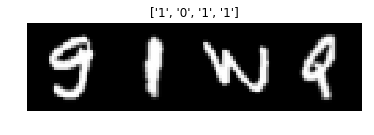

tensor([1, 1, 1, 1])


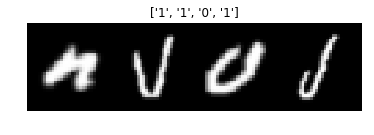

tensor([1, 1, 0, 1])


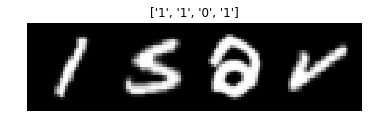

tensor([1, 1, 1, 1])


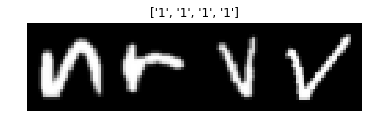

tensor([1, 1, 1, 1])


In [98]:
for i in range(4):
  batch_letters = data_iter_letters.next()
  show_images_batch(batch_letters)
  letters_net.cpu()
  out = letters_net(batch_letters[0])
  # print(out.shape)
  _, pred = torch.max(out,1)
  print(pred)

## Running digit/ letter model according to output of model of Task 1

In [0]:
#net_t1 -> letters_net/ digits_net
# it is not able to perform for batch right now
def vowel_consonant_even_odd_classifier(image):
  # run digits/ letter classifier
  output_1 = net_t1(image)
  _, pred_1 = torch.max(output_1,1)
  if pred_1==0:
    # run even/odd classifier
    output_2 = digits_net(image)
    _, pred_2 = torch.max(output_2,1)
    return 0 if pred_2==0 else 1
  else:
    # run vowel/ consonant classifier
    output_2 = letters_net(image)
    _, pred_2 = torch.max(output_2,1)
    return 2 if pred_2==0 else 3


In [0]:
data_iter_t1 = iter(test_loader_eval) # full data

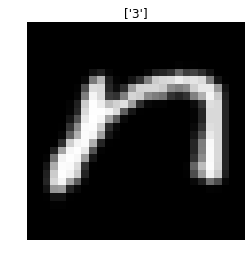

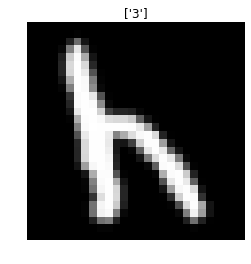

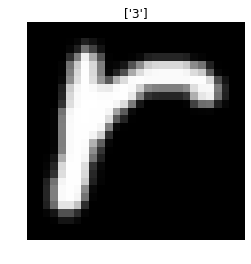

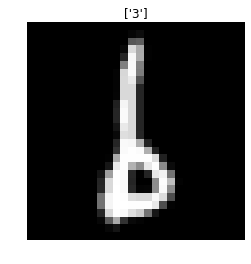

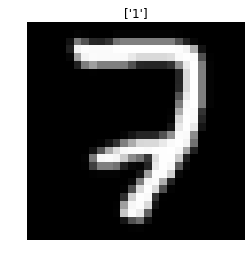

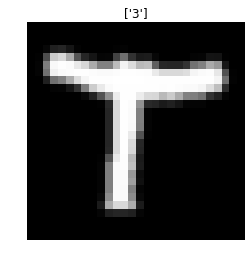

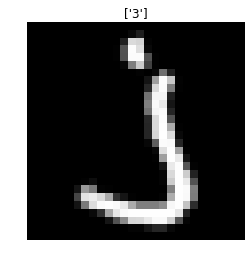

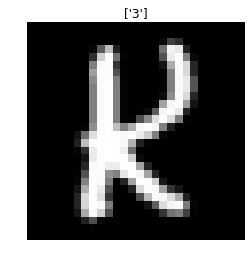

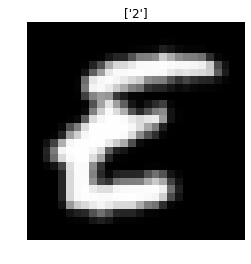

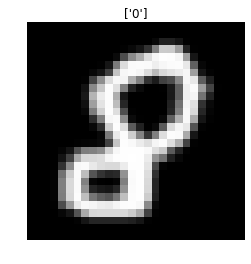

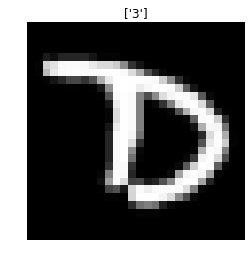

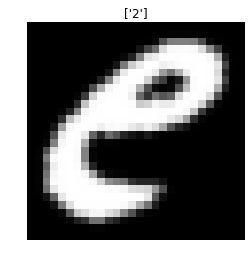

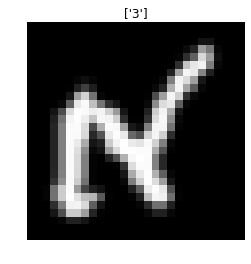

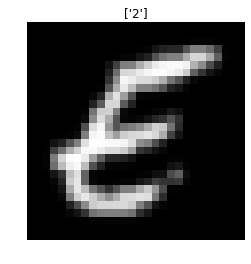

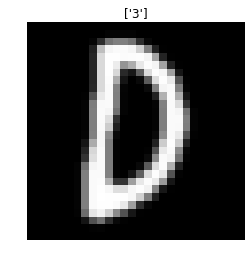

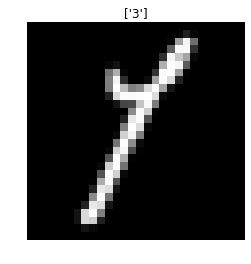

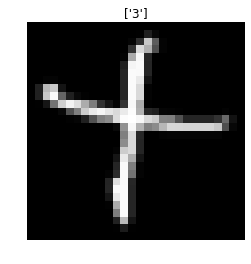

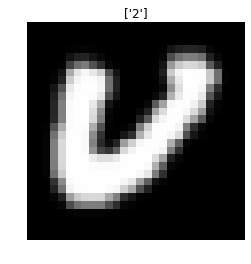

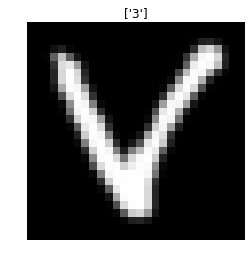

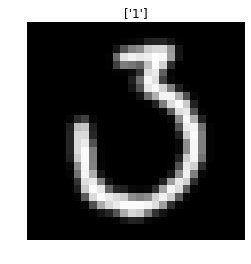

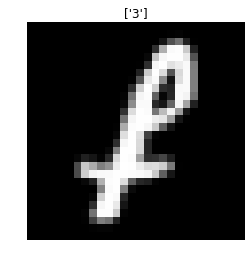

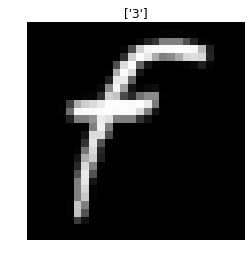

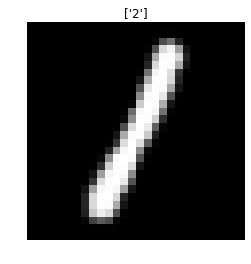

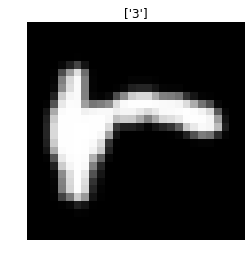

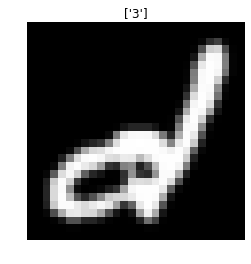

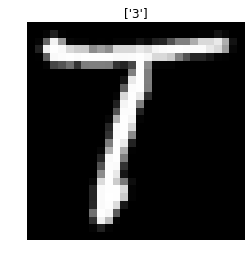

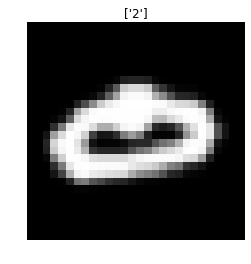

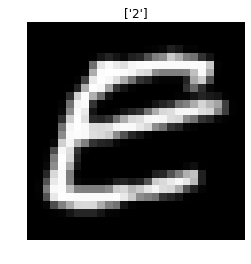

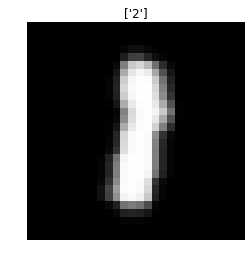

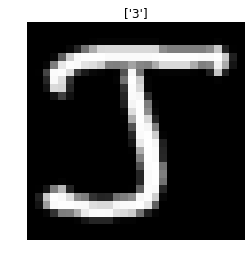

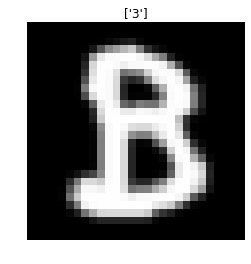

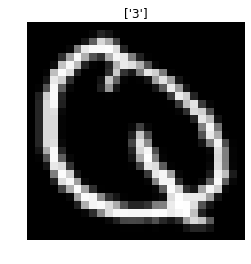

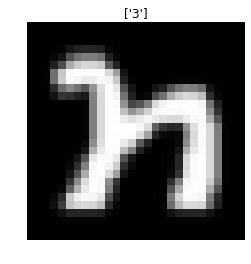

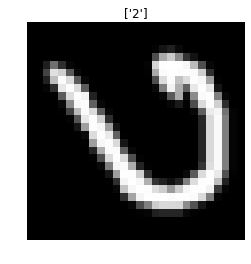

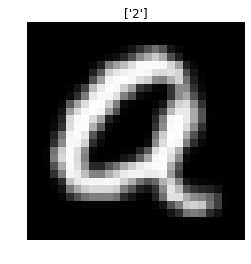

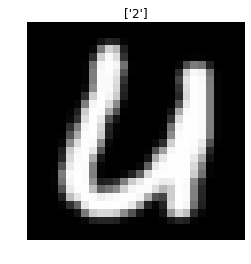

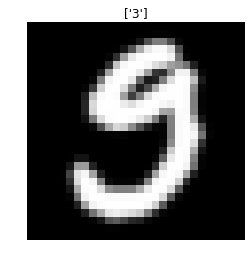

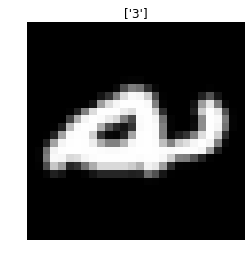

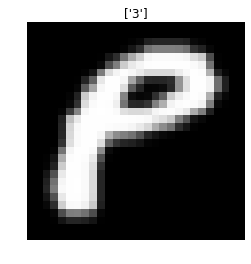

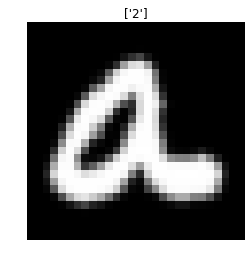

In [101]:
digits_net.cpu()
letters_net.cpu()
net_t1.cpu()

for i in range(40):
  batch = data_iter_t1.next()
  show_images_batch(batch)
  vowel_consonant_even_odd_classifier(batch[0])
# net_t1(batch_letters[0][0].reshape(1,1,28,28)).shape

## Accuracy on Test Set

In [0]:
def evaluate_task2(data_loader,classifier):
  correct,total = 0, 0
  for image, label in data_loader:
    output = classifier(image)
    if output ==label:
      correct = correct+1
    total += label.size(0)
  return 100 * correct / total
    

In [103]:
net_t1.cpu()
digits_net.cpu()
letters_net.cpu()
evaluate_task2(test_loader_eval,vowel_consonant_even_odd_classifier)

87.76063829787235

# TASK 3

## DataLoader

In [104]:
train , val = create_train_val_dataset(images_train,labels_train[:,2],test_size=0.2)
test = create_test_dataset(images_test,labels_test[:,2])

(90240, 1, 28, 28) (90240,)


In [0]:
train_loader = DataLoader(train, batch_size=4,
                        shuffle=True, num_workers=4)
val_loader = DataLoader(val, batch_size=4,
                        shuffle=True, num_workers=4)
test_loader = DataLoader(test, batch_size=4,
                        shuffle=True, num_workers=4)

## Model

In [0]:
# Copied LeNet Model From My Kaggle Notebook
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 6, 5),         # (N, 1, 28, 28) -> (N,  6, 24, 24)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 24, 24) -> (N,  6, 12, 12)
            nn.Conv2d(6, 16, 5),        # (N, 6, 12, 12) -> (N, 16, 8, 8)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 4, 4) -> (N, 16, 4, 4)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(256,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,47)            # (N, 84)  -> (N, 10)
            # note that we are not using softmax because it is not essential, just find the max value amongst all 
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import torch.optim as optim
net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [0]:
MODEL_T3_PATH = PATH + '/trained_models/model_t3.pth'
if load_and_save_mode:
  checkpoint = torch.load(MODEL_T3_PATH)
  net.load_state_dict(checkpoint['model_state_dict'])
  opt.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
# train_model(train_loader,val_loader,test_loader,net,loss_fn,opt,max_epochs=12)

In [111]:
for epoch in range(1, 3 + 1):
                train_v2(train_loader,net,loss_fn,opt,epoch)
                test_v2(val_loader,net,loss_fn,epoch,train_acc=False)

Train Epoch: 1 [0/90240 (0%)]	Loss: 0.434
Train Epoch: 1 [400/90240 (0%)]	Loss: 0.031
Train Epoch: 1 [800/90240 (1%)]	Loss: 0.696
Train Epoch: 1 [1200/90240 (1%)]	Loss: 0.073
Train Epoch: 1 [1600/90240 (2%)]	Loss: 0.025
Train Epoch: 1 [2000/90240 (2%)]	Loss: 0.201
Train Epoch: 1 [2400/90240 (3%)]	Loss: 0.023
Train Epoch: 1 [2800/90240 (3%)]	Loss: 0.497
Train Epoch: 1 [3200/90240 (4%)]	Loss: 0.774
Train Epoch: 1 [3600/90240 (4%)]	Loss: 1.110
Train Epoch: 1 [4000/90240 (4%)]	Loss: 0.063
Train Epoch: 1 [4400/90240 (5%)]	Loss: 0.194
Train Epoch: 1 [4800/90240 (5%)]	Loss: 1.297
Train Epoch: 1 [5200/90240 (6%)]	Loss: 0.671
Train Epoch: 1 [5600/90240 (6%)]	Loss: 0.513
Train Epoch: 1 [6000/90240 (7%)]	Loss: 0.005
Train Epoch: 1 [6400/90240 (7%)]	Loss: 0.232
Train Epoch: 1 [6800/90240 (8%)]	Loss: 0.046
Train Epoch: 1 [7200/90240 (8%)]	Loss: 0.422
Train Epoch: 1 [7600/90240 (8%)]	Loss: 0.061
Train Epoch: 1 [8000/90240 (9%)]	Loss: 0.246
Train Epoch: 1 [8400/90240 (9%)]	Loss: 1.438
Train Epoch: 1 

In [0]:
if load_and_save_mode:
  torch.save({
              # 'epoch': epoch,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              # 'loss': loss,
              }, MODEL_T3_PATH)

## Inference

In [0]:
data_iter = iter(train_loader)

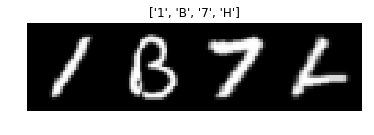

Predictions :  ['1', 'B', '7', 'L']




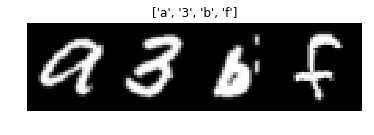

Predictions :  ['a', '3', '6', 'f']




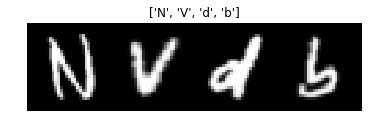

Predictions :  ['N', 'V', 'd', 'b']




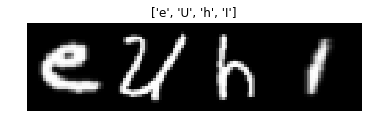

Predictions :  ['e', 'U', 'h', 'I']




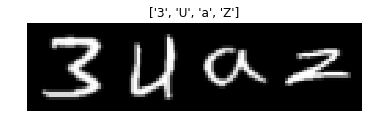

Predictions :  ['3', 'U', 'a', 'Z']




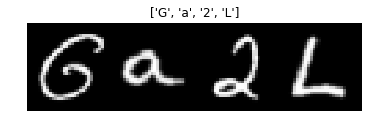

Predictions :  ['G', 'a', '2', 'L']




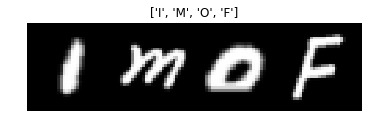

Predictions :  ['I', 'M', 'B', 'F']




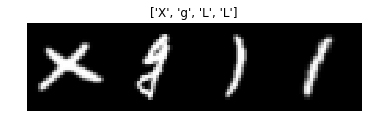

Predictions :  ['X', 'g', 'L', 'I']




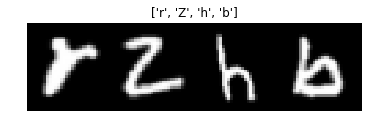

Predictions :  ['r', 'Z', 'h', 'b']




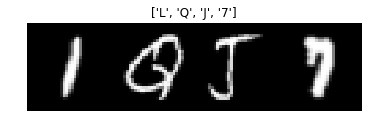

Predictions :  ['I', 'Q', 'J', '7']




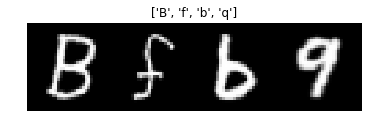

Predictions :  ['B', 'F', 'b', '9']




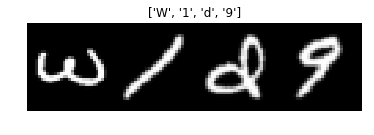

Predictions :  ['W', '1', 'd', '9']




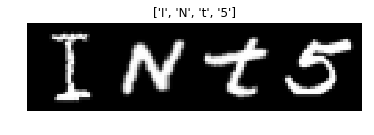

Predictions :  ['I', 'N', 't', '5']




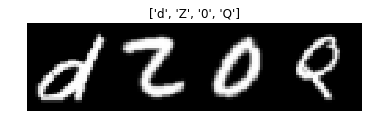

Predictions :  ['d', 'Z', 'O', 'q']




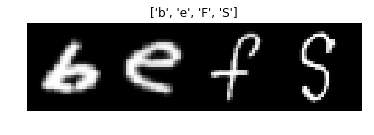

Predictions :  ['6', 'e', 'f', 'S']




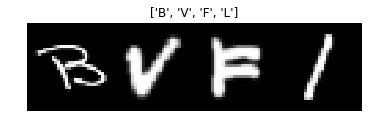

Predictions :  ['B', 'V', 'r', '1']




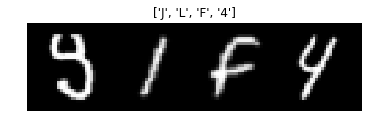

Predictions :  ['Y', 'L', 'f', '4']




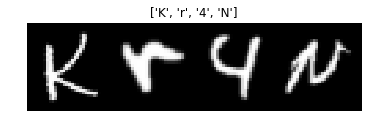

Predictions :  ['K', 'r', '4', 'M']




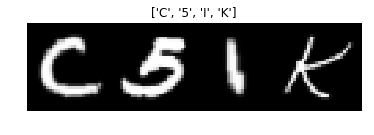

Predictions :  ['C', '5', 'L', 'K']




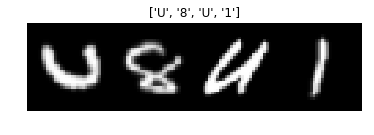

Predictions :  ['U', 'G', 'U', '1']




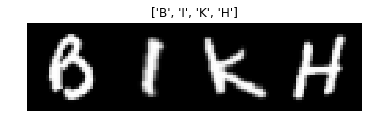

Predictions :  ['B', 'L', 'K', 'H']




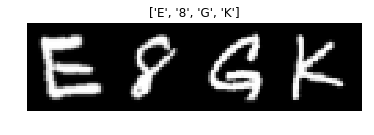

Predictions :  ['E', 'q', 'G', 'K']




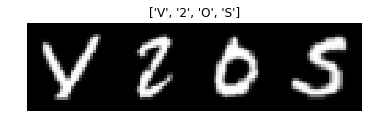

Predictions :  ['Y', '2', 'O', 'S']




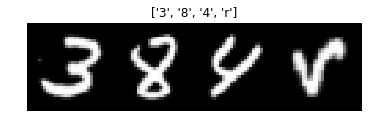

Predictions :  ['3', '8', '4', 'r']




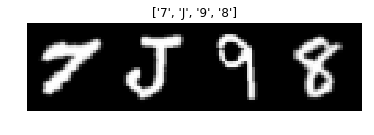

Predictions :  ['7', 'J', '9', '8']




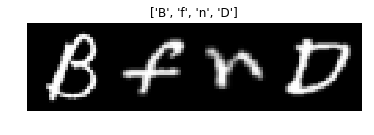

Predictions :  ['B', 'f', 'r', 'D']




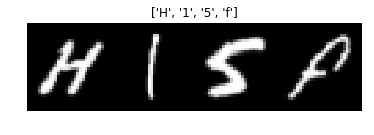

Predictions :  ['H', 'L', '5', 'f']




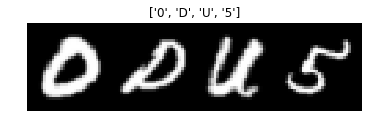

Predictions :  ['O', 'D', 'U', '5']




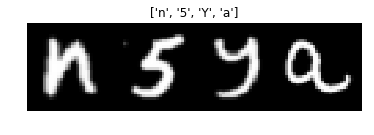

Predictions :  ['n', '5', 'Y', 'a']




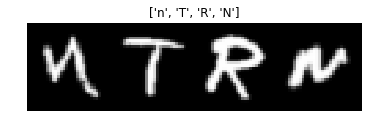

Predictions :  ['q', 'T', 'R', 'N']




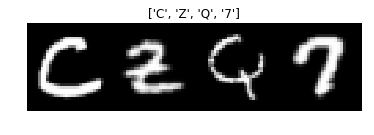

Predictions :  ['C', 'Z', 'Q', '7']




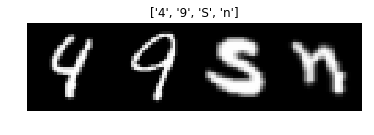

Predictions :  ['4', 'q', 'S', 'n']




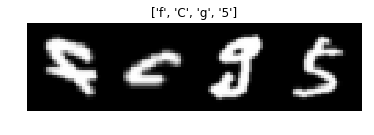

Predictions :  ['F', 'C', 'g', '5']




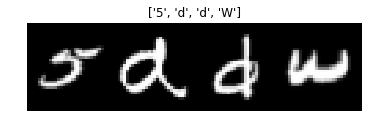

Predictions :  ['5', 'd', 'd', 'W']




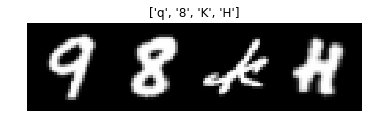

Predictions :  ['q', '8', 'K', 'H']




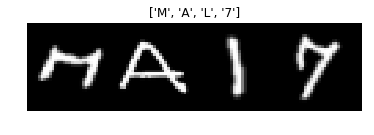

Predictions :  ['M', 'A', '1', '7']




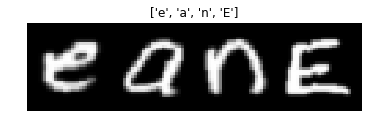

Predictions :  ['e', 'a', 'n', 'E']




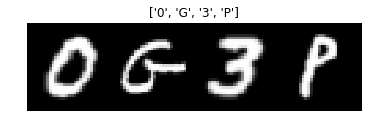

Predictions :  ['O', 'G', '3', 'P']




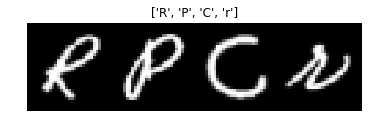

Predictions :  ['R', 'P', 'C', 'N']




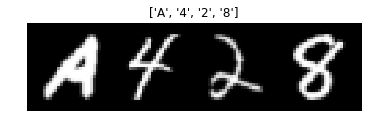

Predictions :  ['A', '4', '2', '8']




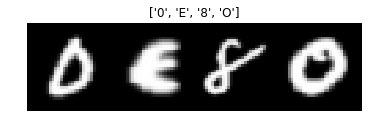

Predictions :  ['D', 'E', '8', 'O']




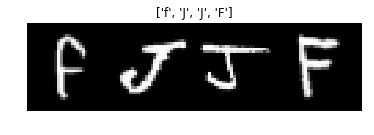

Predictions :  ['F', 'J', 'J', 'F']




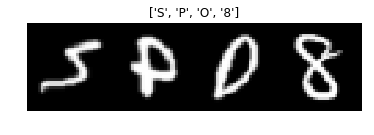

Predictions :  ['S', 'P', 'O', '8']




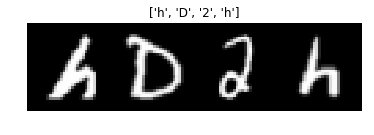

Predictions :  ['h', 'D', '2', 'h']




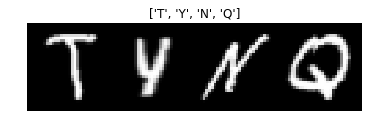

Predictions :  ['T', '4', 'N', 'Q']




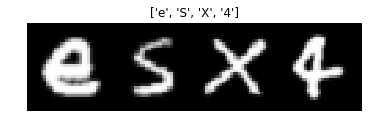

Predictions :  ['e', 'S', 'X', '4']




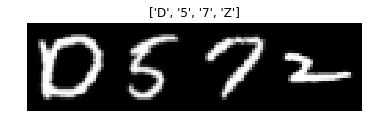

Predictions :  ['D', '5', '7', 'Z']




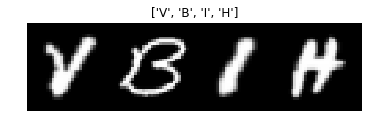

Predictions :  ['V', 'B', 'I', 'H']




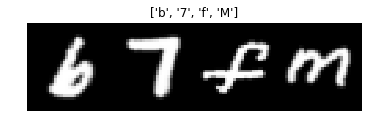

Predictions :  ['b', '7', 'f', 'M']




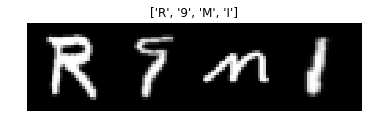

Predictions :  ['R', '7', 'M', 'I']




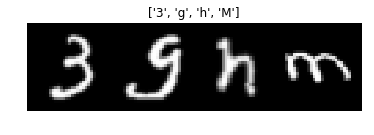

Predictions :  ['3', 'g', 'h', 'M']




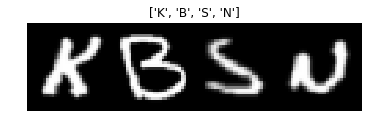

Predictions :  ['K', 'B', 'S', 'N']




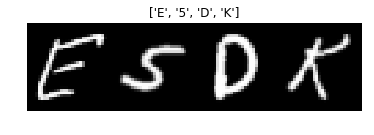

Predictions :  ['E', '5', 'D', 'K']




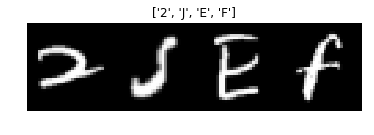

Predictions :  ['2', 'J', 'E', 'f']




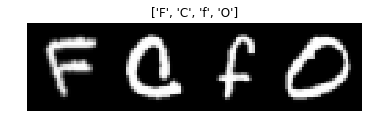

Predictions :  ['F', 'C', 'f', 'O']




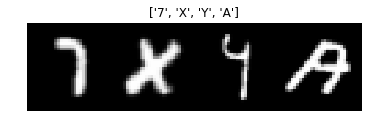

Predictions :  ['7', 'X', 'Y', 'A']




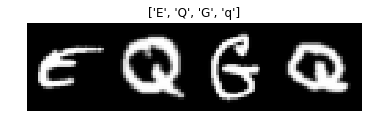

Predictions :  ['E', 'Q', 'G', 'Q']




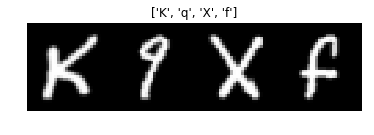

Predictions :  ['K', 'q', 'X', 'f']




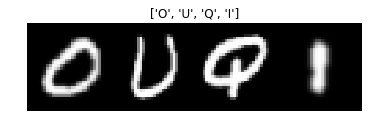

Predictions :  ['0', 'U', 'G', 'L']




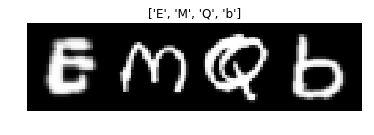

Predictions :  ['E', 'M', 'Q', 'b']




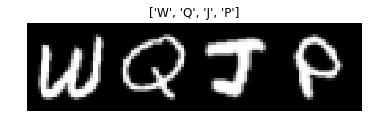

Predictions :  ['W', 'Q', 'J', 'P']




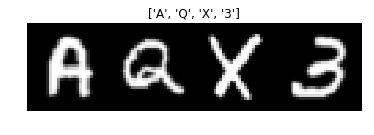

Predictions :  ['A', 'Q', 'X', '3']




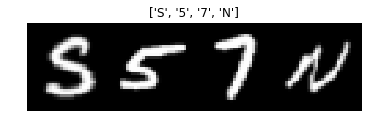

Predictions :  ['S', '5', '7', 'N']




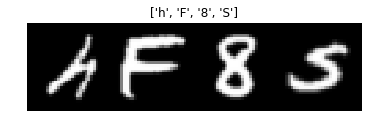

Predictions :  ['h', 'F', '8', 'S']




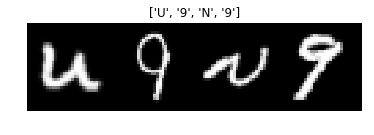

Predictions :  ['U', 'q', 'N', '9']




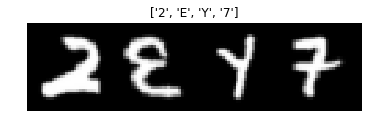

Predictions :  ['2', 'E', 'Y', '7']




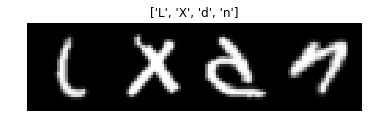

Predictions :  ['L', 'X', 'd', 'n']




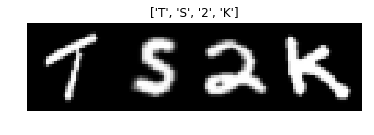

Predictions :  ['T', 'S', '2', 'K']




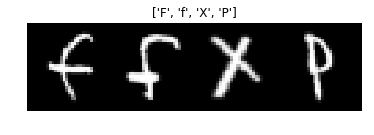

Predictions :  ['f', 'F', 'X', 'P']




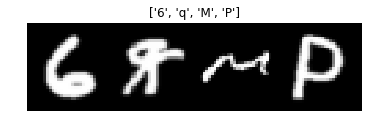

Predictions :  ['6', 'q', 'M', 'P']




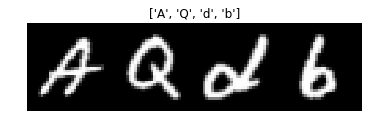

Predictions :  ['A', 'Q', 'd', '6']




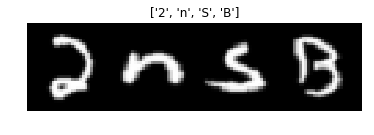

Predictions :  ['2', 'n', 'S', 'B']




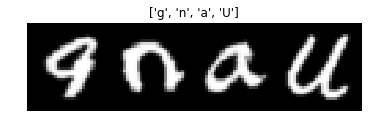

Predictions :  ['q', 'n', 'a', 'U']




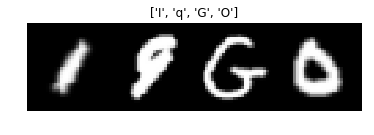

Predictions :  ['I', '9', 'G', 'O']




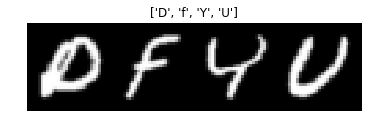

Predictions :  ['D', 'F', 'Y', 'V']




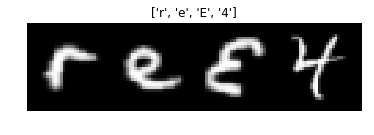

Predictions :  ['r', 'e', 'E', 't']




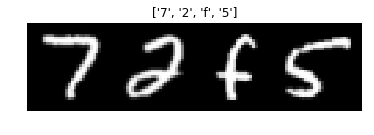

Predictions :  ['7', '2', 'f', '5']




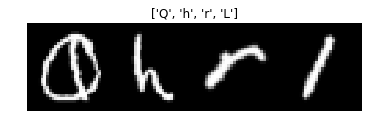

Predictions :  ['Q', 'h', 'r', '1']




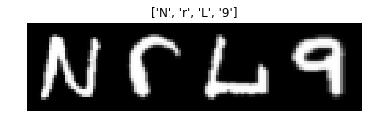

Predictions :  ['N', 'r', 'L', 'q']




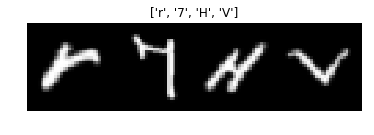

Predictions :  ['r', '7', 'H', 'Y']




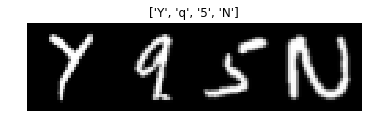

Predictions :  ['Y', 'q', '5', 'N']




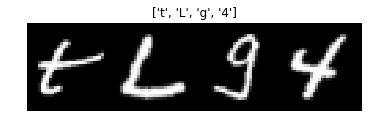

Predictions :  ['t', 'L', 'g', '4']




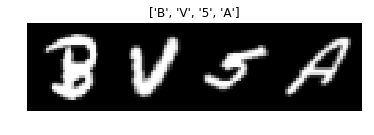

Predictions :  ['B', 'V', '5', 'A']




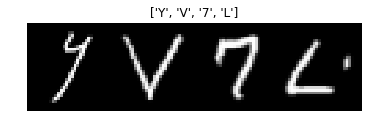

Predictions :  ['q', 'V', '7', 'L']




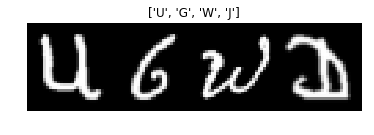

Predictions :  ['U', '6', 'W', 'D']




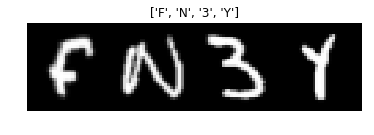

Predictions :  ['f', 'N', '3', 'Y']




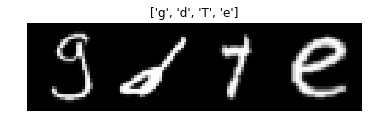

Predictions :  ['g', 'd', '7', 'e']




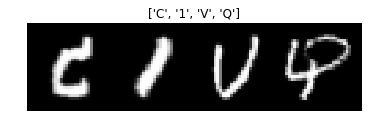

Predictions :  ['C', 'L', 'V', 'q']




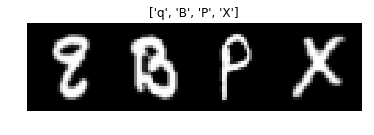

Predictions :  ['q', 'B', 'P', 'X']




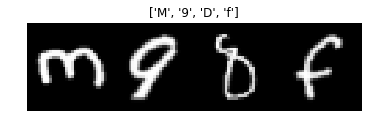

Predictions :  ['M', 'q', 'D', 'f']




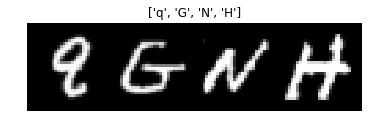

Predictions :  ['q', 'G', 'N', 'H']




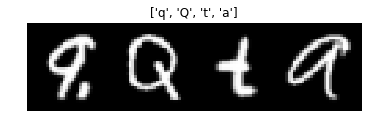

Predictions :  ['q', 'Q', 't', 'a']




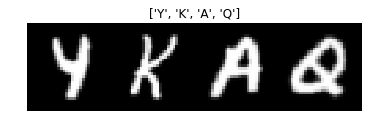

Predictions :  ['Y', 'K', 'A', 'Q']




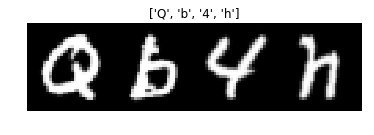

Predictions :  ['Q', 'b', '4', 'h']




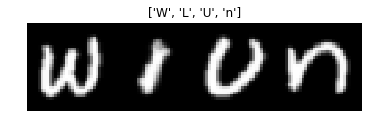

Predictions :  ['W', 'I', 'U', 'n']




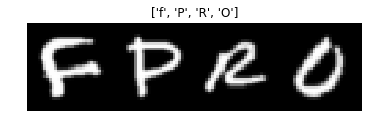

Predictions :  ['F', 'P', 'R', 'O']




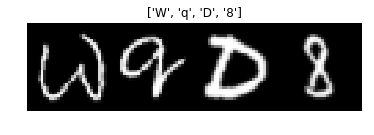

Predictions :  ['W', 'q', 'D', '8']




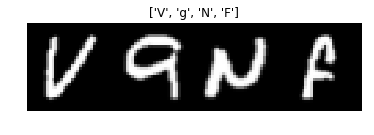

Predictions :  ['V', 'g', 'N', 'f']




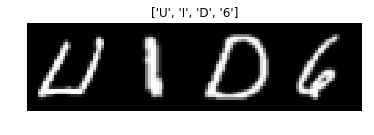

Predictions :  ['U', '1', 'D', '6']




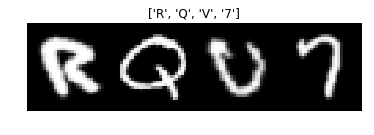

Predictions :  ['R', 'Q', 'U', '7']




In [114]:
net.cpu()
for i in range(100):
  batch = data_iter.next()
  show_images_batch(batch)
  out = net(batch[0])
  # print(out.shape)
  _, pred = torch.max(out,1)
  print('Predictions : ' ,[chr(index_to_ascii[i]) for i in pred.numpy()])
  print('\n')

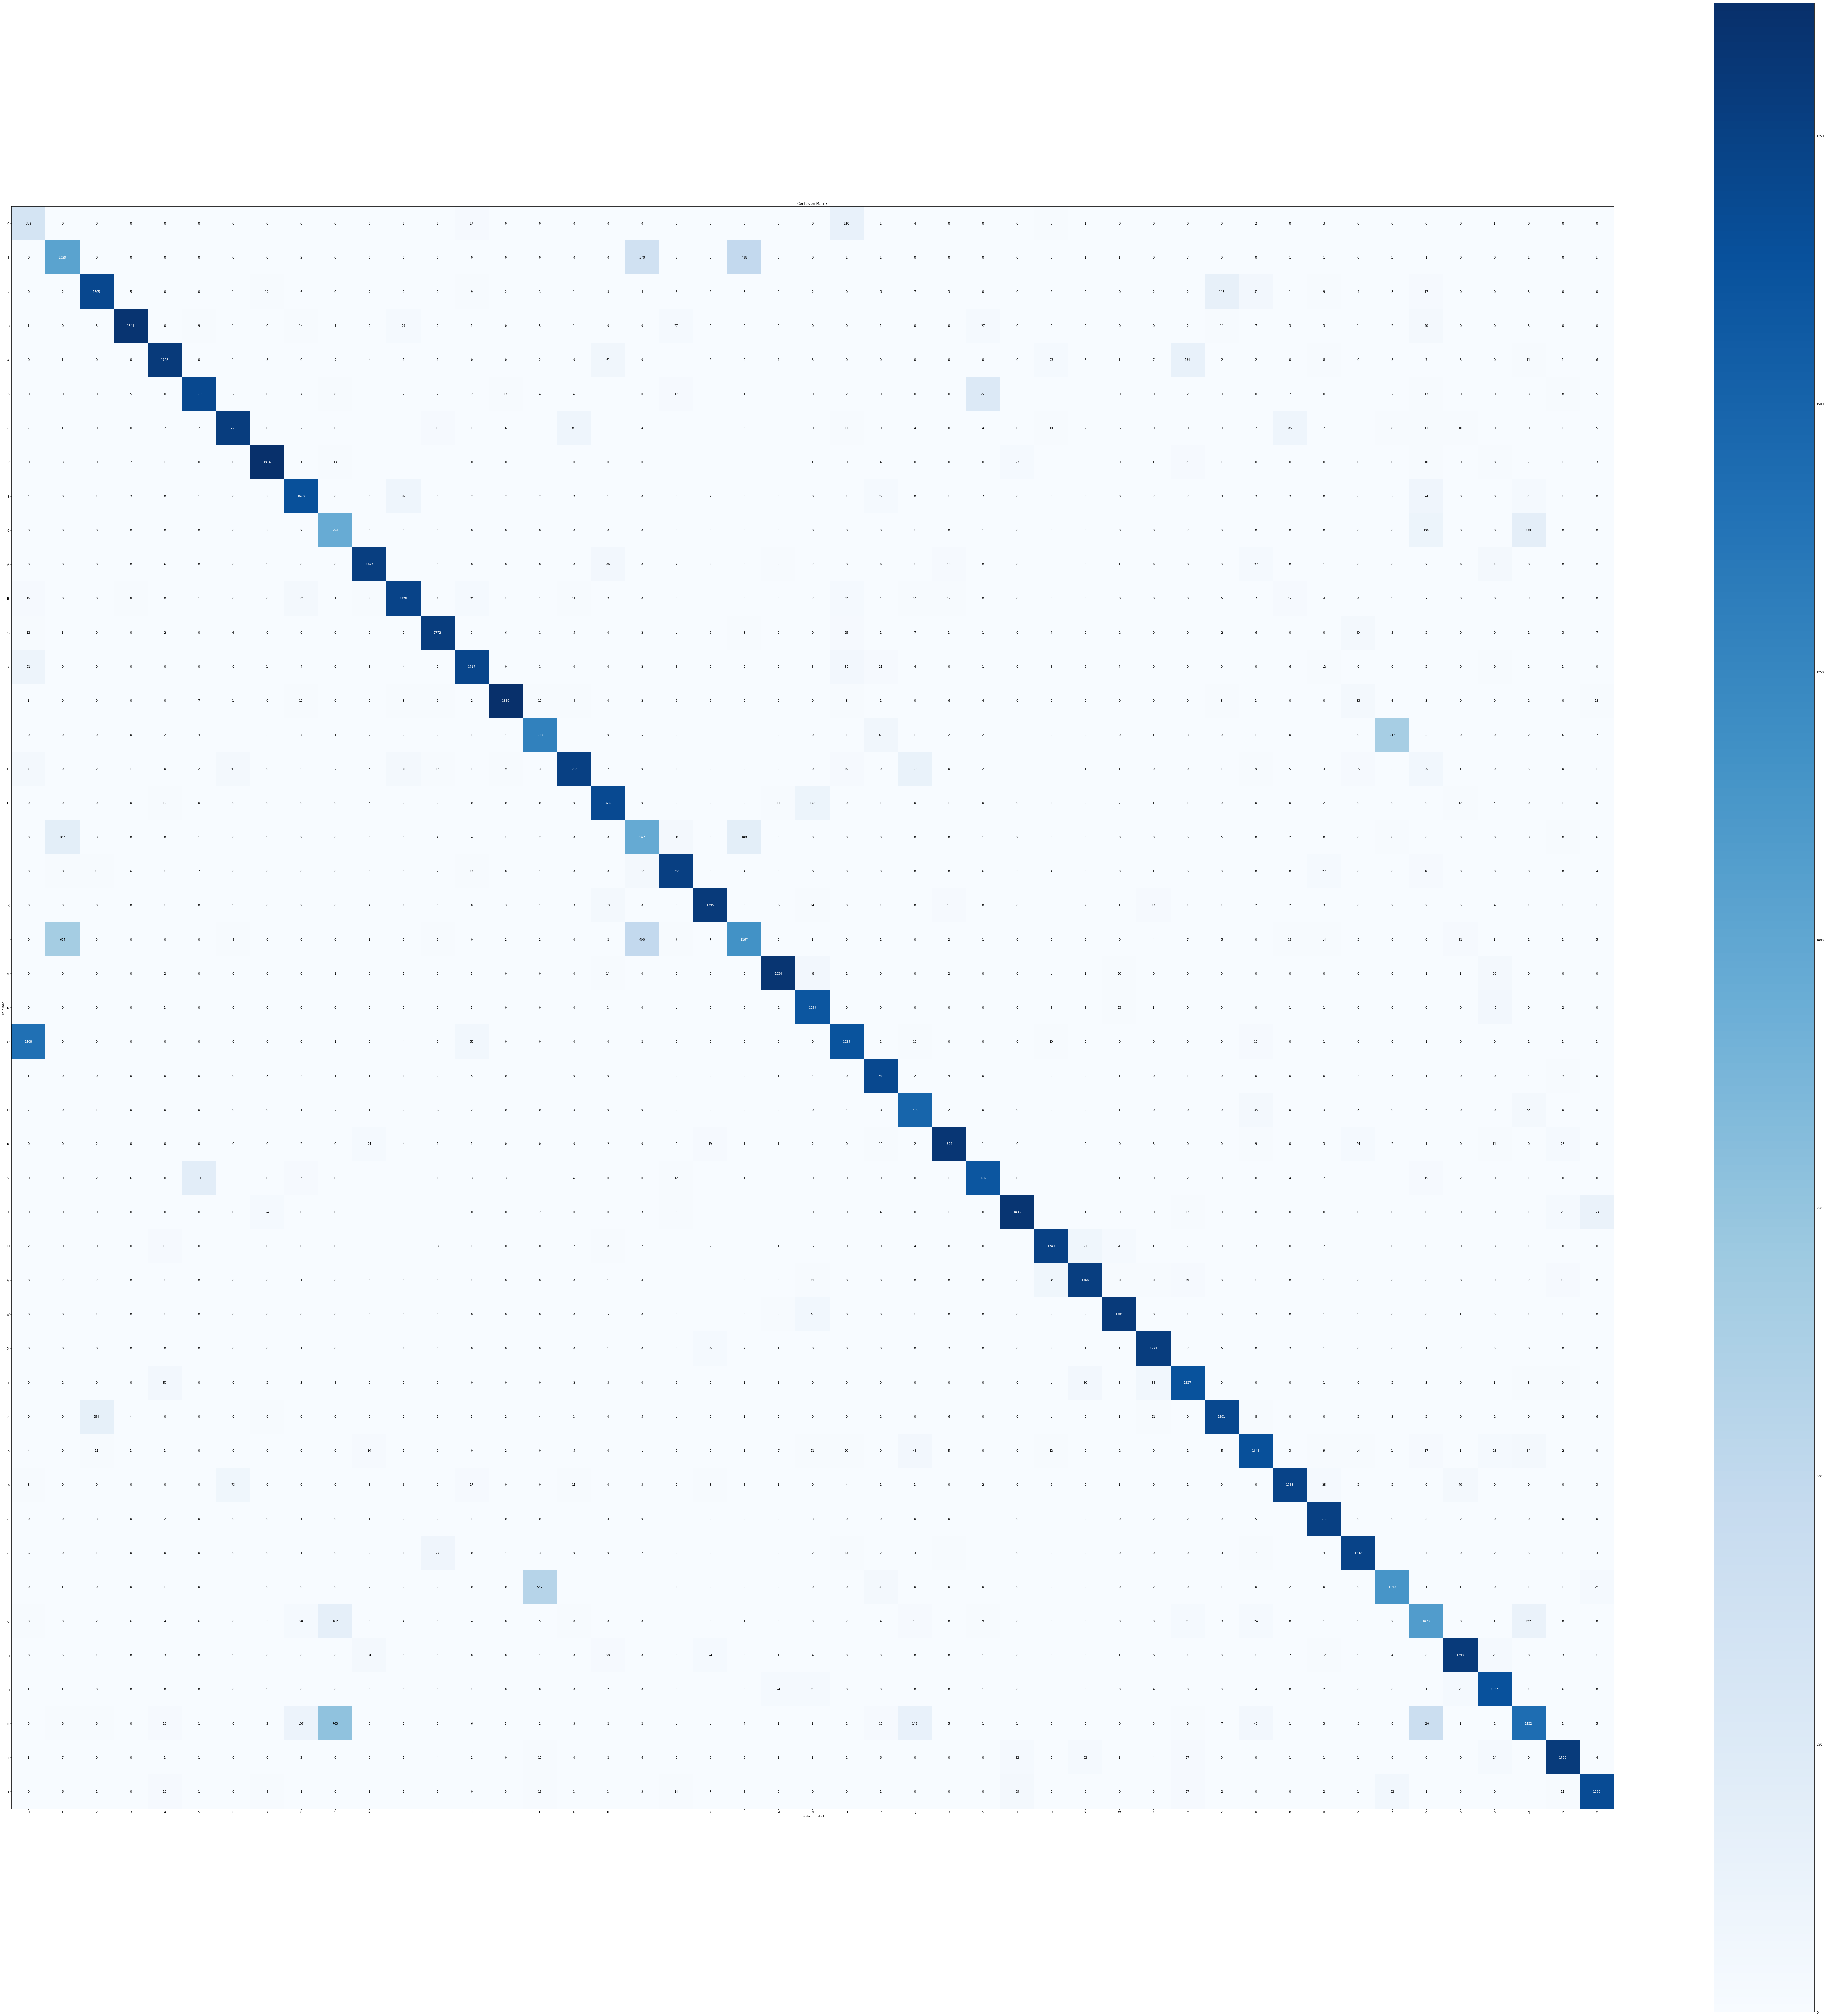

In [115]:
plot_confusion_matrix(train_loader,net,47,classes=classes_t3)

In [116]:
plt.savefig('confusion.jpg')

<Figure size 432x288 with 0 Axes>

## Accuracy on Test Set

In [117]:
evaluation(test_loader,net,calc_loss=False,loss_fn=None)

81.37765957446808

#Saving Models to Disk

In [118]:
torch.save(net_t1,'task1_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeNet_T1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dis

In [0]:
model = torch.load('task1_model.pth')

In [120]:
torch.save(digits_net,'task2_digits_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeNet_T2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dis

In [121]:
torch.save(letters_net,'task2_letters_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeNet_T2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dis

In [122]:
torch.save(net,'task3_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-p

In [0]:
# for i, j in zip (range(47),classes_t3):
#   print(str(i) +' -> '+j +' <br/>')